Using Sumit Mukhija's project as source: https://towardsdatascience.com/a-beginners-guide-to-kaggle-s-titanic-problem-3193cb56f6ca

In [18]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input style = "float:right" type="submit" value="Toggle code">''')


In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
#import wordcloud
#from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
#from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
from scipy.stats import pearsonr

c:\Users\gugah\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [25]:
# Setting up visualisations
sns.set_style(style='white') 
sns.set(rc={
    'figure.figsize':(10,5), 
    'axes.facecolor': 'white',
    'axes.grid': True, 'grid.color': '.9',
    'axes.linewidth': 1.0,
    'grid.linestyle': u'-'},font_scale=1.5)
custom_colors = ["#3498db", "#95a5a6","#34495e", "#2ecc71", "#e74c3c"]
sns.set_palette(custom_colors)

In [3]:
#Reading the data from the CSV file.

trd = pd.read_csv(r"C:\Users\gugah\Desktop\Titanic-master\train.csv")
tsd = pd.read_csv(r"C:\Users\gugah\Desktop\Titanic-master\test.csv")

td = pd.concat([trd, tsd], ignore_index=True, sort  = False)


### 1. Initial analysis

The data contains 1309 rows and 12 colunmns.

In [8]:
td.shape

(1309, 12)

On diving deeper in to the columns, we see five integer type columns, five object types (strings) and two columns with decimal values. Also, all the columns do not have 1309 values which indicates that there are missing values.

In [9]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


### 2. NaN values

Columns that have missing values

- Age 
- Cabin
- Embarked
- Fare
- Survived

**77.5%** of data is NOT available for the column 'Cabin' and as such, it will be dropped in out analysis.

Embarked only has two missing values and research shows us that both embarked from the 'S' location.

The column 'Age' on the other hand has 177 missing values which contribute to **20%** on the total expected values. We will impute the age data by categorising people on the basis of their title and finding the median age.

Fare has one missing value.

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

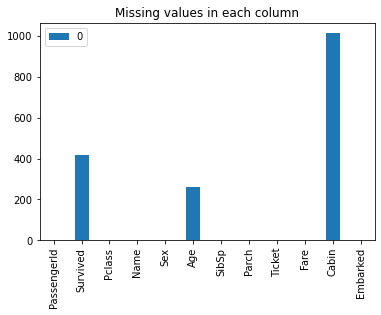

In [12]:
pd.DataFrame(td.isnull().sum()).plot.bar().set_title("Missing values in each column")
td.isnull().sum()

Text(0.5, 1, 'Missing values heatmap')

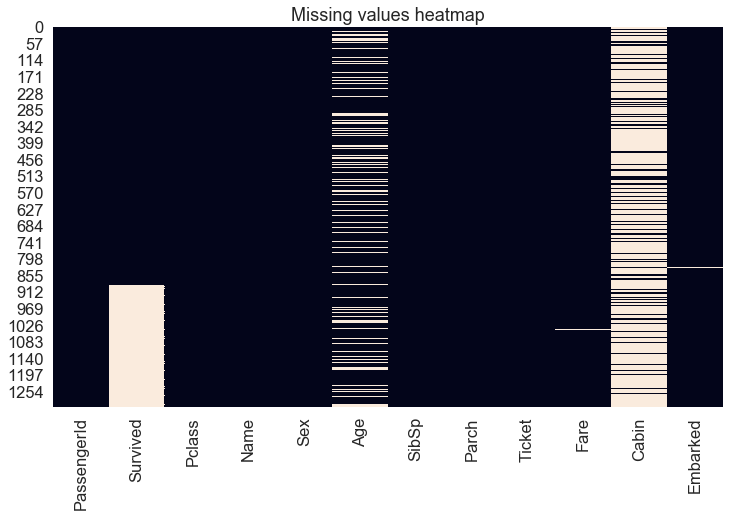

In [8]:
sns.heatmap(td.isnull(), cbar = False).set_title("Missing values heatmap")


### 3. Number of unique values
Four columns of cateogrical data - **Survived, Sex, Embarked and PClass**.

In [9]:
td.nunique()

PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin           186
Embarked          3
dtype: int64

# Features

### 4. Survived ###

**More than 60% of the people on the ship died.**

Text(0.5, 1.0, 'Training Data - Percentage of people survived and Deceased')

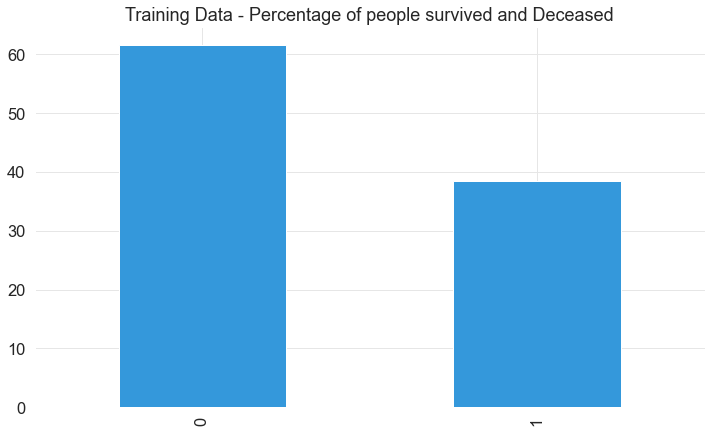

In [22]:
(trd.Survived.value_counts(normalize=True) * 100).plot.bar().set_title("Training Data - Percentage of people survived and Deceased")


### 5. Pclass ###

Pclass refers to the passenger's traveling class, P1, P2 and P3. In the dataset, a majority **(709)** traveled in the third class, followed by the second **(277)** and then the first **(323)**. 

**The number of passengers in the third class was more than the number of passengers in first and second class combined.**

**More than 40% of the first class passengers were rescued.**, around **70% of the second class passengers lost their lives**. More than **80% of the third class passengers lost their lives** in the disaster.




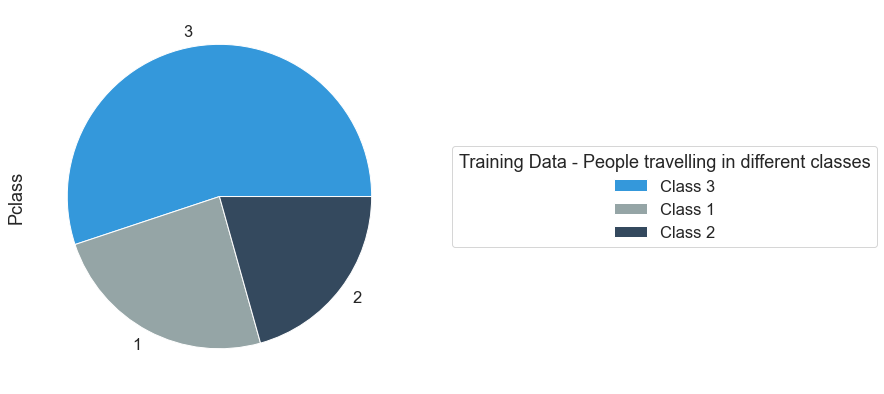

In [21]:
pclass_piechart = trd.Pclass.value_counts().plot.pie().legend(labels=["Class 3","Class 1","Class 2"], loc='center right', bbox_to_anchor=(2.25, 0.5)).set_title("Training Data - People travelling in different classes")


### 6. Sex

Roughly around **65% of the tourists were male** while the remaining 35% were female. However, the percentage of female survivors was higher than the number of male survivors.

More than 80% male passengers had to die as compared to around 70% female passengers.

KeyError: 1

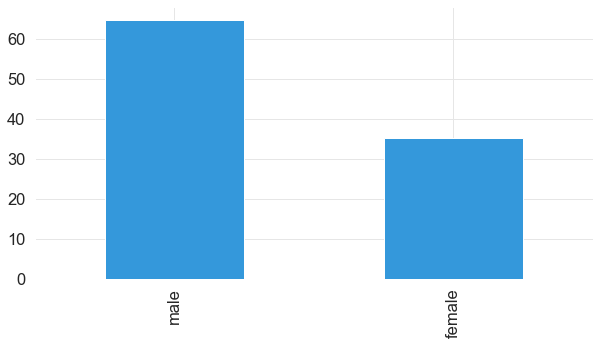

In [30]:
fig_sex = (trd.Sex.value_counts(normalize = True) * 100).plot.bar()
male_pr = round((trd[trd.Sex == 'male'].Survived == 1).value_counts()[1]/len(trd.Sex) * 100, 2)
female_pr = round((trd[trd.Sex == 'female'].Survived == 1).value_counts()[1]/len(trd.Sex) * 100, 2)

fig_sex

### 7. Age

The youngest passenger onboard was around 2 months and the oldest passenger was 80 years old.

In [17]:
pd.DataFrame(td.Age.describe())

,Age
count,1046.000000
mean,29.881138
std,14.413493
min,0.170000
25%,21.000000
50%,28.000000
75%,39.000000
max,80.000000


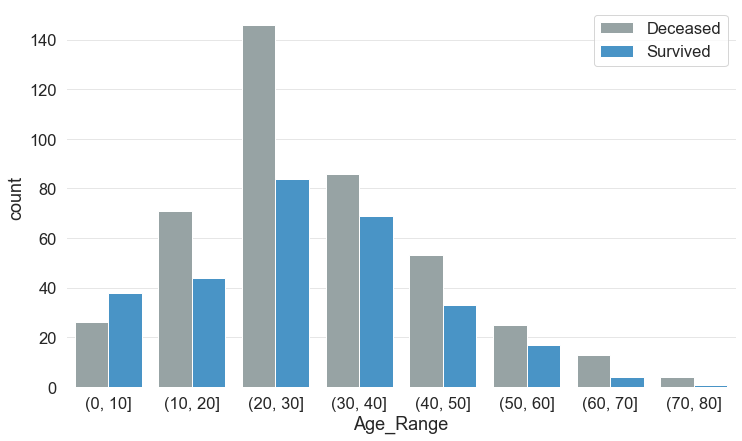

In [18]:
td['Age_Range'] = pd.cut(td.Age, [0, 10, 20, 30, 40, 50, 60,70,80])
sns.countplot(x = "Age_Range", hue = "Survived", data = td, palette=["C1", "C0"]).legend(labels = ["Deceased", "Survived"])


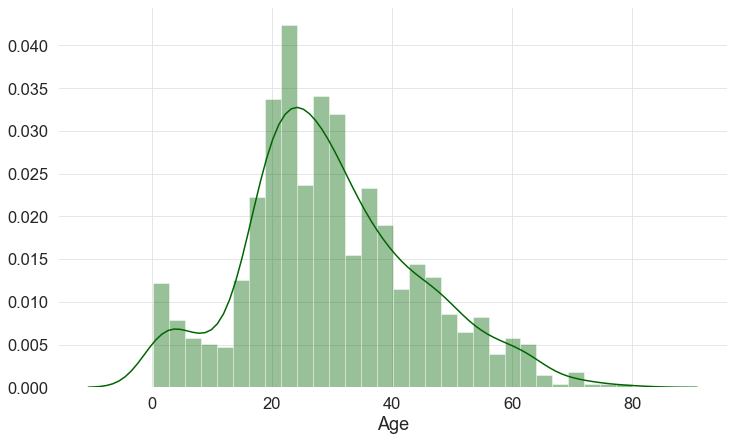

In [19]:
sns.distplot(td['Age'].dropna(),color='darkgreen',bins=30)

### 8. SibSp

SibSp is the number of siblings or spouse of a person onboard.

Around 90% people traveled alone or with one of their sibling or spouse.

Odds of survival are significantly lower for people traveling with 2 or more family members.

In [20]:
td.SibSp.describe()

count    1309.000000
mean        0.498854
std         1.041658
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         8.000000
Name: SibSp, dtype: float64

Text(0.5, 1.0, 'Number of siblings or spouses X survived')

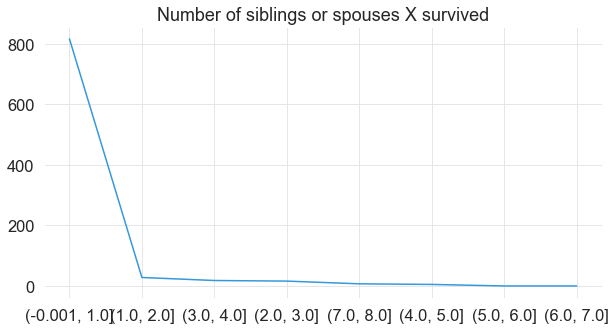

In [34]:
ss = pd.DataFrame()
ss['survived'] = trd.Survived
ss['sibling_spouse'] = pd.cut(trd.SibSp, [0, 1, 2, 3, 4, 5, 6, 7, 8], include_lowest = True)
(ss.sibling_spouse.value_counts()).plot.line().set_title("Number of siblings or spouses X survived")

### 9. Parch

Number of parents or children each passenger was traveling with.

Column with both Parch and SibSp values summed is created as 'family' 

With how much traveling alone impacted one's chances of survival, a column Is_Alone is created.



In [23]:
pd.DataFrame(td.Parch.describe())

,Parch
count,1309.000000
mean,0.385027
std,0.865560
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,9.000000


Text(0.5, 1.0, 'Number of parents/children and survival density')

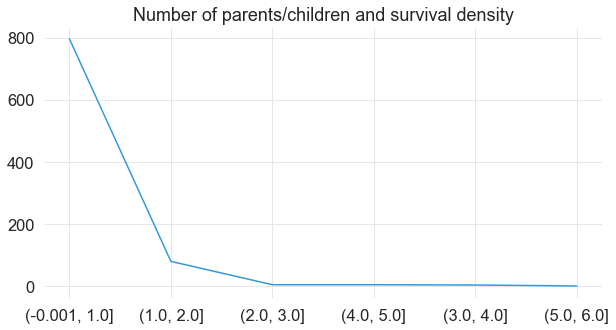

In [37]:
pc = pd.DataFrame()
pc['survived'] = trd.Survived
pc['parents_children'] = pd.cut(trd.Parch, [0, 1, 2, 3, 4, 5, 6], include_lowest = True)
(pc.parents_children.value_counts()).plot.line().set_title("Number of parents/children and survival density")

In [26]:
td['Family'] = td.Parch + td.SibSp
td['Is_Alone'] = td.Family == 0

### 10. Ticket



This column is not considered as it provides no useful information in our dataset (it is essentially the passenger's ID.)

### 11. Fare

The data shows us that the higher a tourist paid, the higher would be their chances to survive.

In [27]:
td.Fare.describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [28]:
td['Fare_Category'] = pd.cut(td['Fare'], bins=[0,7.90,14.45,31.28,120], labels=['Low','Mid',
                                                                                      'High_Mid','High'])

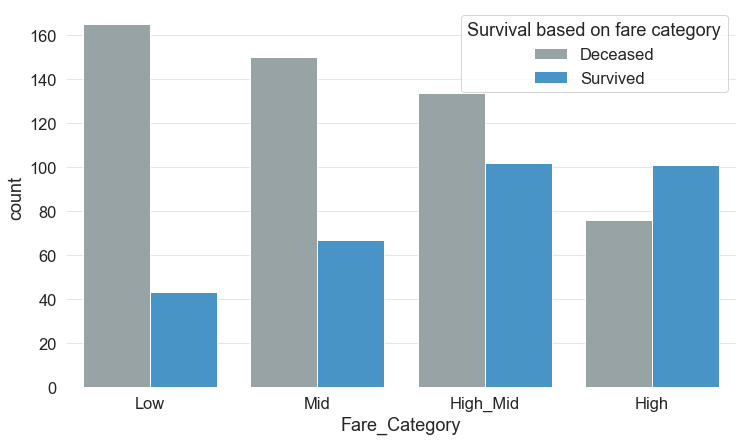

In [29]:
x = sns.countplot(x = "Fare_Category", hue = "Survived", data = td, palette=["C1", "C0"]).legend(labels = ["Deceased", "Survived"])
x.set_title("Survival based on fare category")


### 12. Cabin

As Cabin has a lot of missing values, we will impute it in following section and then use it for prediction.


### 13. Embarked

Embarked signifies where the traveler boarded from. There are three possible values for Embark - Southampton, Cherbourg, Queenstown.

More than **70% of the people boarded from Southampton. Under 20% boarded from Cherbourg and the rest boarded from Queenstown.**

More People who **boarded from Cherbourg survived than those who died**

Text(0.5, 1.0, 'Training Data - Survival based on embarking point.')

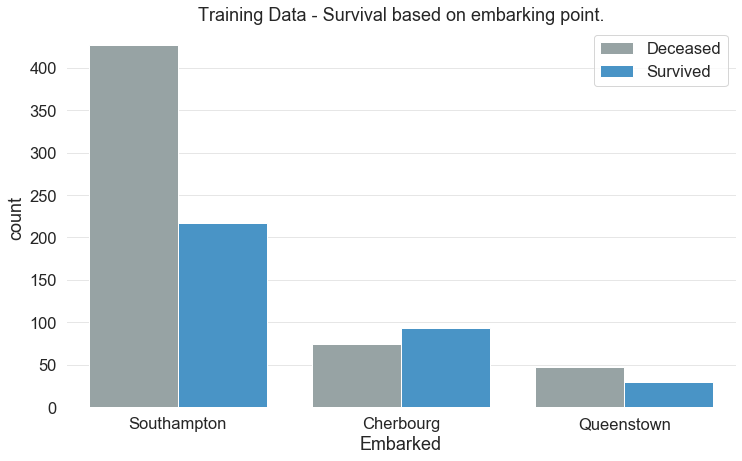

In [30]:
p = sns.countplot(x = "Embarked", hue = "Survived", data = trd, palette=["C1", "C0"])
p.set_xticklabels(["Southampton","Cherbourg","Queenstown"])
p.legend(labels = ["Deceased", "Survived"])
p.set_title("Survival based on embarking point.")

# Pearson Correlation between numerical data
Overral, the numerical data does not seem to be strongly linked, either positively or negatively.

Correlation between age and fare: 


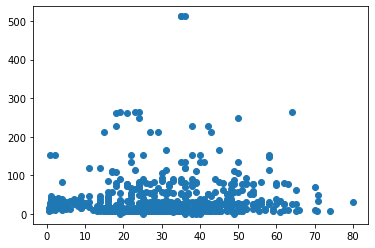

Correlation between age and number of siblings and spouses present: 


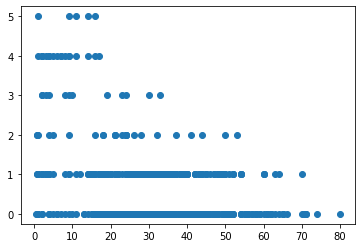

Correlation between age and number of parents and children present: 


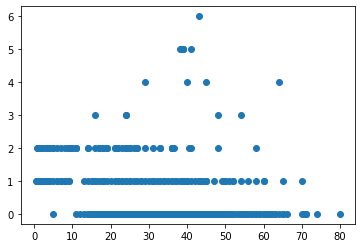

Correlation between fare and number of siblings and spouses present: 


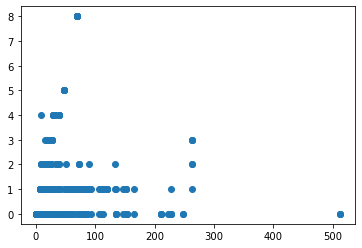

Correlation between fare and number of parents and children present: 


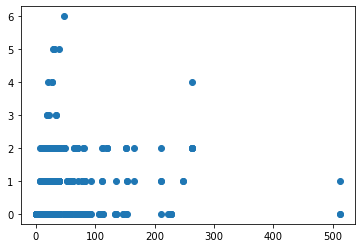

Correlation between number of siblings and spouses present and number of parents and children present: 


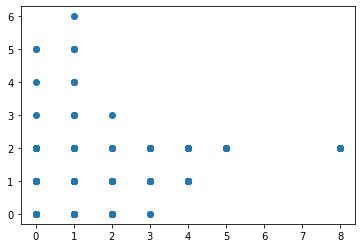

In [6]:
list1 = trd['Age']
list2 = trd['Fare']
list3 = trd['SibSp']
list4 = trd['Parch']



print('Correlation between age and fare: ')

plt.show()
plt.scatter(list1, list2)
plt.show()
print('Correlation between age and number of siblings and spouses present: ')

plt.scatter(list1, list3)
plt.show()
print('Correlation between age and number of parents and children present: ')

plt.scatter(list1, list4)
plt.show()
print('Correlation between fare and number of siblings and spouses present: ')

plt.scatter(list2, list3)
plt.show()
print('Correlation between fare and number of parents and children present: ')

plt.scatter(list2, list4)
plt.show()
print('Correlation between number of siblings and spouses present and number of parents and children present: ')

plt.scatter(list3, list4)
plt.show()

# Skewness analysis
Every single column of numeric data except for age displays Skewness.

c:\Users\gugah\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


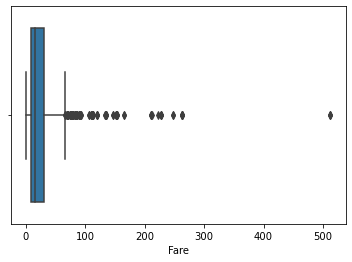

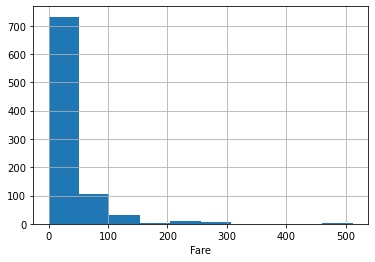

c:\Users\gugah\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


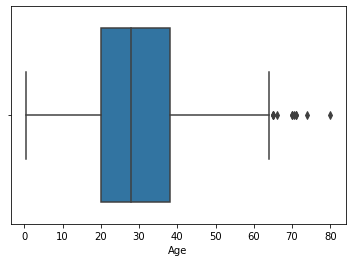

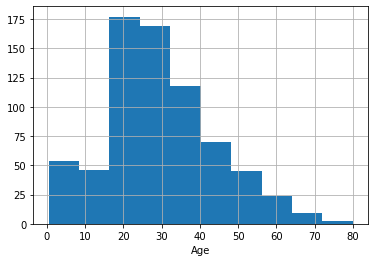

c:\Users\gugah\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


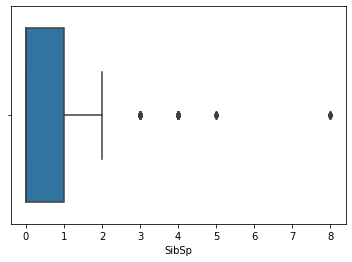

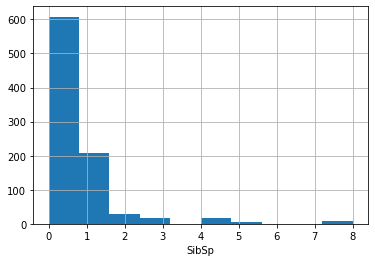

c:\Users\gugah\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


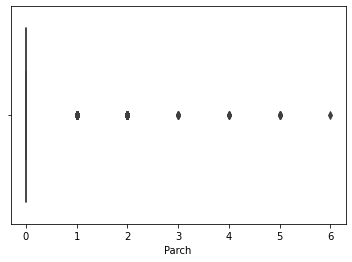

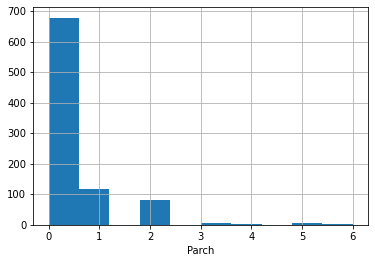

skewness value of Age:  0.38910778230082704
skewness value of Fare:  4.787316519674893
skewness value of SibSp:  3.6953517271630565
skewness value of Parch:  2.7491170471010933


In [7]:

#Fare
sns.boxplot(trd['Fare'])
plt.xlabel('Fare')
plt.show()

trd['Fare'].hist()
plt.xlabel('Fare')
plt.show()

#Age
sns.boxplot(trd['Age'])
plt.xlabel('Age')
plt.show()

trd['Age'].hist()
plt.xlabel('Age')
plt.show()

#SibSp
sns.boxplot(trd['SibSp'])
plt.xlabel('SibSp')
plt.show()

trd['SibSp'].hist()
plt.xlabel('SibSp')
plt.show()

#Parch
sns.boxplot(trd['Parch'])
plt.xlabel('Parch')
plt.show()

trd['Parch'].hist()
plt.xlabel('Parch')
plt.show()



print('skewness value of Age: ',trd['Age'].skew())
print('skewness value of Fare: ',trd['Fare'].skew())
print('skewness value of SibSp: ',trd['SibSp'].skew())
print('skewness value of Parch: ',trd['Parch'].skew())

# Data Imputation

### Embarked

With only two missing values and the clear majority of passengers hailing from South Hampton, we will fill in the missing values with 'S'.

In [31]:
td.Embarked.fillna(td.Embarked.mode()[0], inplace = True)

### Age

Age has **263 missing values**. To deal with missing values, we first try to categorise the people with their titles. There are **17 different titles** in the training data. We group the titles and sex and then we find the median of all the categories and replace the missing values with the median of that category.

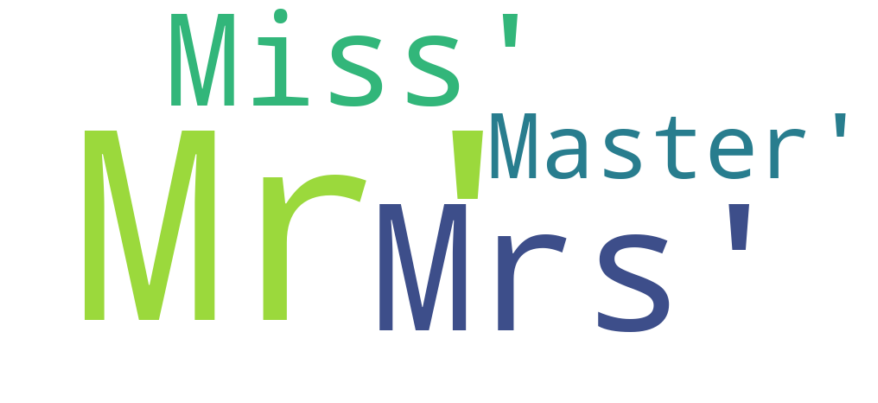

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Ms                2
Mlle              2
Major             2
Dona              1
Don               1
Jonkheer          1
Sir               1
the Countess      1
Capt              1
Mme               1
Lady              1
Name: Salutation, dtype: int64

In [32]:
td['Salutation'] = td.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip()) 
td.Salutation.nunique()
wc = WordCloud(width = 1000,height = 450,background_color = 'white').generate(str(td.Salutation.values))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

td.Salutation.value_counts()

In [33]:
grp = td.groupby(['Sex', 'Pclass'])  
td.Age = grp.Age.apply(lambda x: x.fillna(x.median()))

#If still any row remains
td.Age.fillna(td.Age.median, inplace = True)

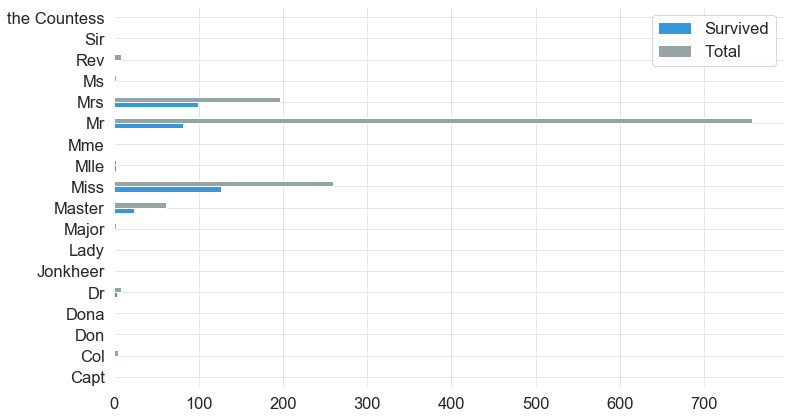

In [34]:
sal_df = pd.DataFrame({
    "Survived":
    td[td.Survived == 1].Salutation.value_counts(),
    "Total":
        td.Salutation.value_counts()
})
s = sal_df.plot.barh()

### Cabin

Assigning NA for non available cabin values. Pulling deck value from Cabin and adding a feature 'Deck'

In [35]:
td.Cabin = td.Cabin.fillna('NA')

# Encoding & dropping columns

Using Pandas' get dummies we encoded the categorical data. Later, we drop all the columns we encoded.

In [36]:
td = pd.concat([td,pd.get_dummies(td.Cabin, prefix="Cabin"),pd.get_dummies(td.Age_Range, prefix="Age_Range"), pd.get_dummies(td.Embarked, prefix="Emb", drop_first = True), pd.get_dummies(td.Salutation, prefix="Title", drop_first = True),pd.get_dummies(td.Fare_Category, prefix="Fare", drop_first = True), pd.get_dummies(td.Pclass, prefix="Class", drop_first = True)], axis=1)
td['Sex'] = LabelEncoder().fit_transform(td['Sex'])
td['Is_Alone'] = LabelEncoder().fit_transform(td['Is_Alone'])

In [37]:
td.drop(['Pclass', 'Fare','Cabin', 'Fare_Category','Name','Salutation', 'Ticket','Embarked', 'Age_Range', 'SibSp', 'Parch', 'Age'], axis=1, inplace=True)


# Prediction

1. Gaussian Naive Bayes
2. Random Forest

NB Accuracy: 61.45%
The cross validated score for GNB is: 64.61


Text(0.5, 1.05, 'Confusion_matrix for NB')

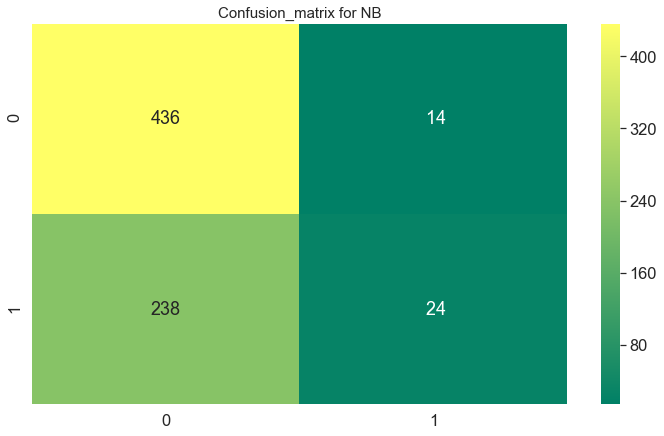

In [38]:
# Data to be predicted
X_to_be_predicted = td[td.Survived.isnull()]
X_to_be_predicted = X_to_be_predicted.drop(['Survived'], axis = 1)

#Training data
train_data = td
train_data = train_data.dropna()
feature_train = train_data['Survived']
label_train  = train_data.drop(['Survived'], axis = 1)
train_data.shape #891 x 28

##Gaussian
clf = GaussianNB()
x_train, x_test, y_train, y_test = train_test_split(label_train, feature_train, test_size=0.2)
clf.fit(x_train,  np.ravel(y_train))
print("NB Accuracy: "+repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")
result_rf=cross_val_score(clf,x_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for GNB is:',round(result_rf.mean()*100,2))
y_pred = cross_val_predict(clf,x_train,y_train,cv=10)
sns.heatmap(confusion_matrix(y_train,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix for NB', y=1.05, size=15)

In [ ]:
##Random forest
clf = RandomForestClassifier(criterion='entropy', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
x_train, x_test, y_train, y_test = train_test_split(label_train, feature_train, test_size=0.2)
clf.fit(x_train,  np.ravel(y_train))
print("RF Accuracy: "+repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")

result_rf=cross_val_score(clf,x_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for Random forest is:',round(result_rf.mean()*100,2))
y_pred = cross_val_predict(clf,x_train,y_train,cv=10)
sns.heatmap(confusion_matrix(y_train,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix for RF', y=1.05, size=15)

RF Accuracy: 89.39%
The cross validated score for Random forest is: 80.94


In [ ]:
result = clf.predict(X_to_be_predicted)
submission = pd.DataFrame({'PassengerId':X_to_be_predicted.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'Titanic Predictions.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

<footer id="attribution" style="float:right; color:#999; background:#fff;">
github.com/sumitmukhija
</footer>